# Data exploration and report

The objective of this notebook is to present a brief report of the input data and explain the chosen modeling approach

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('src'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [8]:
import pandas as pd
import numpy as np
from datetime import datetime

import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline
matplotlib.style.use('ggplot')
plt.rcParams['figure.figsize'] = (30, 5)

import warnings
warnings.filterwarnings('ignore')

import logging

[2019-11-13 20:24:32,423] [DEBUG] [Loaded backend module://ipykernel.pylab.backend_inline version unknown.] [--> /home/alexander/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py [22410]:]


In [9]:
logger = logging.getLogger()
logger.setLevel(logging.INFO)

## 1. Load data and get initial reports

In [10]:
raw = pd.read_csv('src/input_data/input_data.csv')
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14960 entries, 0 to 14959
Data columns (total 17 columns):
date                           14960 non-null object
cnt_rooms                      14960 non-null int64
flat_area                      14960 non-null float64
rent_base                      14960 non-null float64
rent_total                     14960 non-null float64
flat_type                      14960 non-null object
flat_interior_quality          14960 non-null object
flat_condition                 14960 non-null object
flat_age                       14960 non-null object
flat_thermal_characteristic    10099 non-null float64
has_elevator                   14960 non-null object
has_balcony                    14960 non-null object
has_garden                     14960 non-null object
has_kitchen                    14960 non-null object
has_guesttoilet                14960 non-null object
geo_city                       14960 non-null object
geo_city_part                  14960 non

The majory of the features are categorical, which means that after one hot encoding the dimentionality of our problem will increase.

For some of these fatures however ordinal encoding will suit much better (flat_age) and also will keep the dimentionality of the problem low

Let's look at the continious variables and the target

In [11]:
raw.describe()

,cnt_rooms,flat_area,rent_base,rent_total,flat_thermal_characteristic
count,14960.000000,14960.000000,14960.000000,14960.000000,10099.000000
mean,2.473396,67.043695,830.266037,1014.962983,120.540348
std,0.828071,24.519923,418.544930,489.487467,64.224420
min,1.000000,11.000000,0.000000,0.000000,1.000000
25%,2.000000,51.330000,550.000000,695.000000,76.000000
50%,2.000000,64.000000,733.480000,899.025000,119.100000
75%,3.000000,80.000000,1000.000000,1220.000000,150.550000
max,4.000000,242.000000,8950.000000,16401.000000,1716.000000


We have some 0 values in out target variable rent_total - those samples are clearly errors and will have to be removed

flat_thermal_characteristic is missing ~ 30% of it's values. Simple mean imputer could used for that

Appart from haveing total rent we are also provided with base rent, which total rent minus utilities.

Intuitively we know that these base rent and utilitiy bill are not nessesarily correlated. Probably utility bill have a stronger seasonal component whereas base rent is dependent on the supply-demand ballance on the market.

Let's see what is the connection between them:

Correlation coeff: (0.6325611432450474, 0.0)


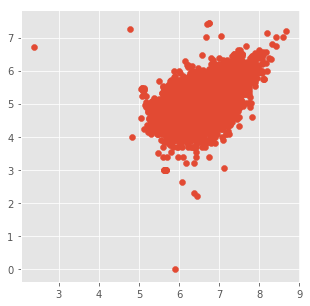

In [12]:
from scipy.stats import pearsonr 
from controllers import load_controller
from controllers.model_controller import *

data = load_controller.load_from_csv('src/input_data/input_data.csv')
X, base, utilities = load_controller.frame_to_features_and_targets(data)

plt.rcParams['figure.figsize'] = (5, 5)
plt.scatter(np.log(base), np.log(utilities))
plt.rcParams['figure.figsize'] = (30, 5)

print('Correlation coeff: {}'.format(pearsonr(base, utilities)))


As expected, there's strong correlation between them but it seems that we will gain more information if we chose to model them separately

This is a time-series problem, however the data is presented as a single datapoints in time.

Generally speaking, we want a model such that given apartment characterictics and current rent the model will forcast rent for the next 6 months. The model will have to generalize the change of rent based over given attributes.

Let's see if we have enough data to be able to make such predictions

In [13]:
print('average number of samples per day: {}'.format(int(raw.groupby('date')['rent_total'].count().mean())))

average number of samples per day: 40


Let's see how many features we get after all the encodings and transformations are done

In [14]:
from controllers.model_controller import *
reg = BaseRegressorModel()
reg.fit(X, base)
transformer = reg.get_pipeline().steps[0][1]
num_features = transformer.transform(X).shape[1]

print('Number of features after transformations: {}'.format(num_features))

Number of features after transformations: 37


We see that it's almost the same as number of samples per day. That is not enough for the model to generalize over. Based on that we chose to model the price change on a monthly basis.

In [15]:
raw['date'] = pd.to_datetime(raw['date'])

print('average number of samples per week: {}'.format(int(raw.groupby([pd.Grouper(key='date', freq='w')])['rent_total'].count().mean())))
print('average number of samples per month: {}'.format(int(raw.groupby([pd.Grouper(key='date', freq='M')])['rent_total'].count().mean())))

average number of samples per week: 282
average number of samples per month: 1150


## 2. Approach to modeling

The dataset at hand provides general seasonal trends based on apartment attributes. To be able to predict the change in price based on the current price and apartment attributes we need to solve 2 tasks:
1. Determine seasonal changes for a given apartment
2. Scale these changes to the current apartment's rent

For the first task I have chosen Random Forest Regressor. It is a good choice for an MVP model since it doesn't usually need hyperparameter tutning, immune to overvitting and delivers good results overall.

As mentioned above, I am modeling base rent and utilities separately.

Let's see how accurate we can predict prices based on apartment attributes

In [16]:
reg = BaseRegressorModel()
reg.fit(X, base)
print('Base price model R2 = {}'.format(reg.model_score))

reg.fit(X, utilities)
print('Utilities price model R2 = {}'.format(reg.model_score))


Base price model R2 = 0.8158706777937409
Utilities price model R2 = 0.5706338714596408


Let's look closer at the utilities model:

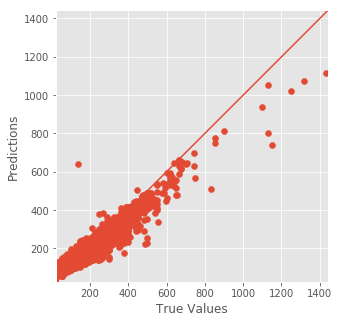

In [17]:
def plot_results(y_true, y_pred):
    a = plt.axes(aspect='equal')
    plt.scatter(y_true, y_pred)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    lims = [min(y_pred), max(y_pred)]
    plt.xlim(lims)
    plt.ylim(lims)
    _ = plt.plot(lims, lims)
    
pred = reg.predict(X)
plot_results(utilities, pred)

We can see that this model can be improved by spending more time on outliers. One could set up an automated procedure where in a loop a point with the biggest RMSE is removed until the improvement in the overall RMSE stops being significant, like below:

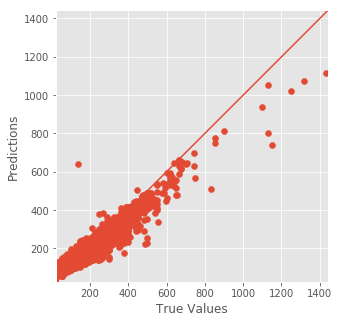

iteration 0, crossval score: 0.5706338714596408
iteration 1, crossval score: 0.570718303899235
iteration 2, crossval score: 0.5754980820051816
iteration 3, crossval score: 0.5829535453964051
iteration 4, crossval score: 0.5908541252201149
iteration 5, crossval score: 0.5978913510303002
iteration 6, crossval score: 0.6017119271919275
iteration 7, crossval score: 0.6002331219337734
iteration 8, crossval score: 0.601274444691285
iteration 9, crossval score: 0.6110175011174979
iteration 10, crossval score: 0.625029527979679
iteration 11, crossval score: 0.6232554020713337
iteration 12, crossval score: 0.6261667451844568
iteration 13, crossval score: 0.6272744583331139
iteration 14, crossval score: 0.6278444221100745
iteration 15, crossval score: 0.6278618167126285
iteration 16, crossval score: 0.6302225640255095
iteration 17, crossval score: 0.6300033922890071
iteration 18, crossval score: 0.630263704189589
iteration 19, crossval score: 0.6300600175386695


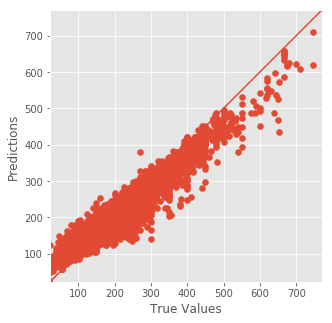

In [20]:
y = utilities
model = BaseRegressorModel()

model.fit(X, y)
y_pred = model.predict(X)
plot_results(y, y_pred)
plt.show()

new_X = X[:]
new_y = y[:]

drop_inds = []

scores = []

for i in range(20):
    scores.append(model.model_score)
    print('iteration {}, crossval score: {}'.format(i, scores[-1]))
    errors = [(y_t - y_p)**2 for y_t, y_p in zip(new_y, y_pred)]
    drop_number = np.argmax(errors)
    drop_inds.append(new_X.index[[drop_number]])
    new_X = new_X.drop(new_X.index[drop_number])
    new_y = new_y.drop(new_y.index[drop_number])
    
    model.fit(new_X, new_y)
    y_pred = model.predict(new_X)
    
model.fit(new_X, new_y)
y_pred = model.predict(new_X)
plot_results(new_y, y_pred)
plt.show()

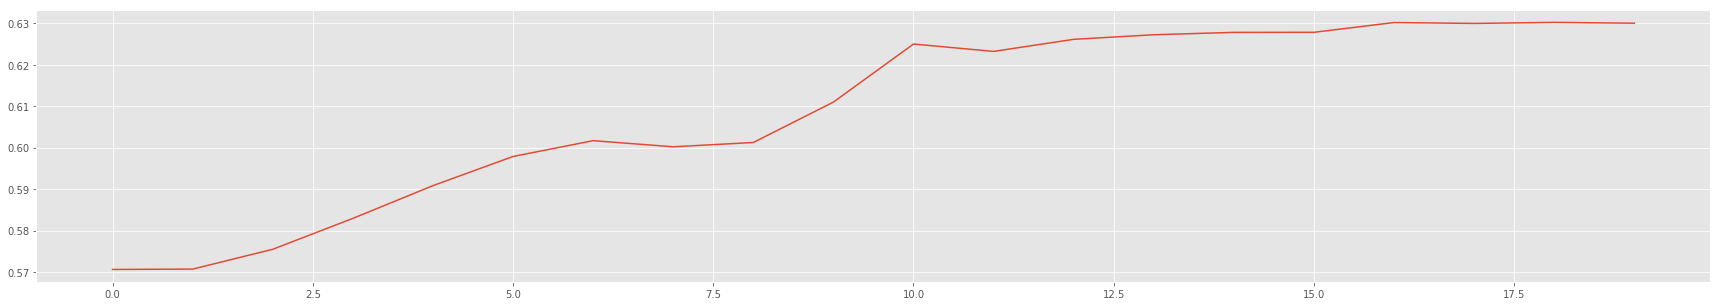

In [21]:
plt.plot(scores)

We can see that after iteration 10 we got rid of all the "bad" samples

## 3. Scoring the model

To evaluate out model we will use a few apartments that can be traced through time. they may not be actual same apartments but for our purposes haveing same attributes means being the same

[2019-11-13 20:36:00,918] [DEBUG] [Initializing cross validation] [--> /home/alexander/Documents/interviews/aboutyou/rent_price/src/train_model.py [22410]:]
[2019-11-13 20:36:00,919] [DEBUG] [Loading input data] [--> /home/alexander/Documents/interviews/aboutyou/rent_price/src/train_model.py [22410]:]
[2019-11-13 20:36:01,264] [DEBUG] [Input data loaded] [--> /home/alexander/Documents/interviews/aboutyou/rent_price/src/train_model.py [22410]:]


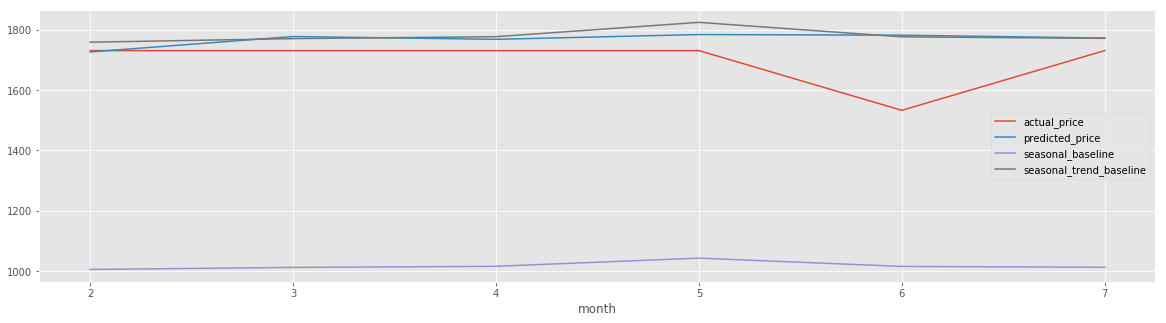

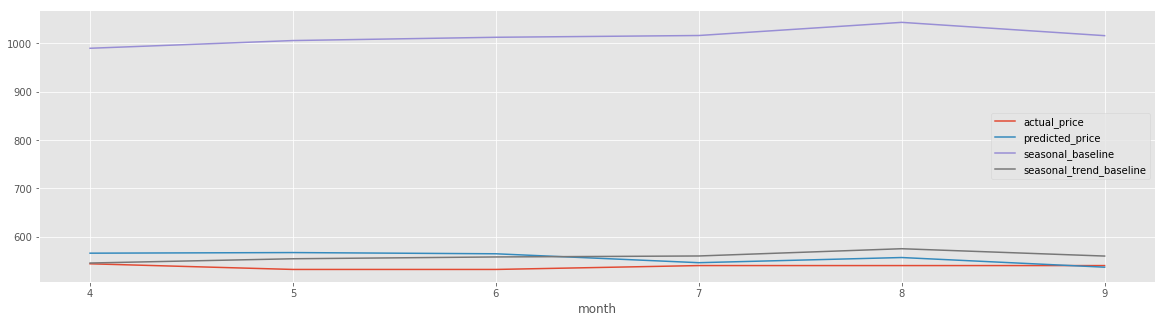

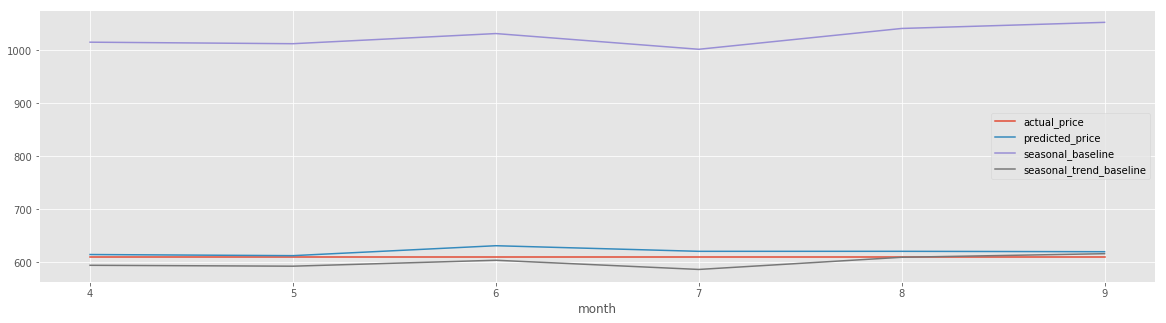

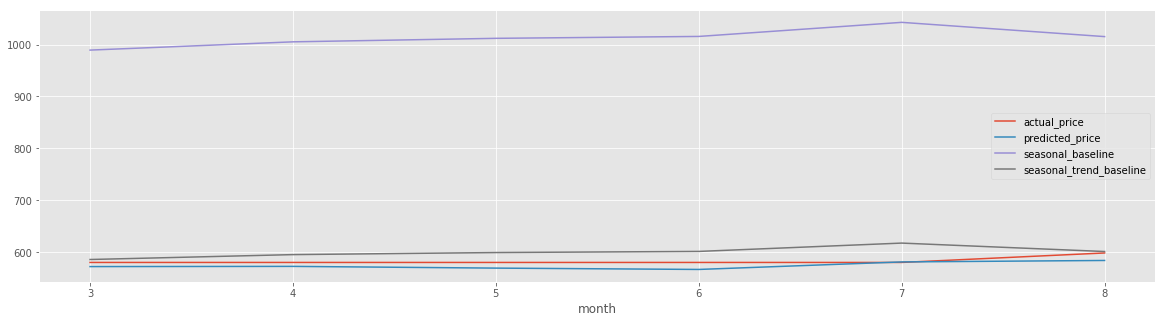

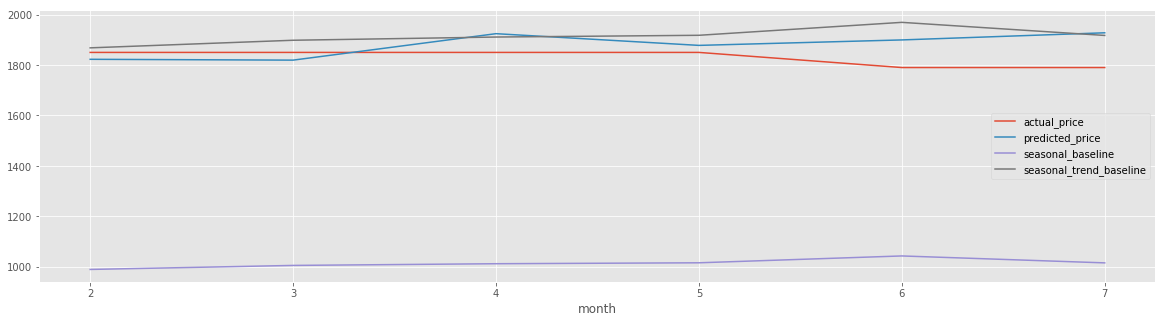

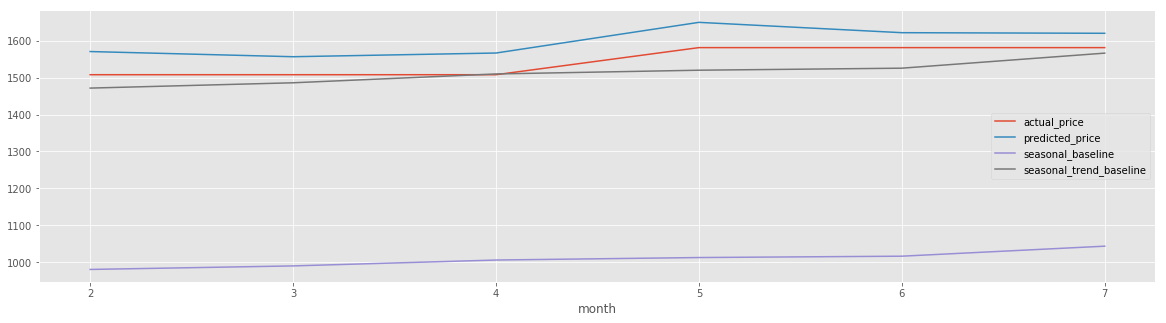

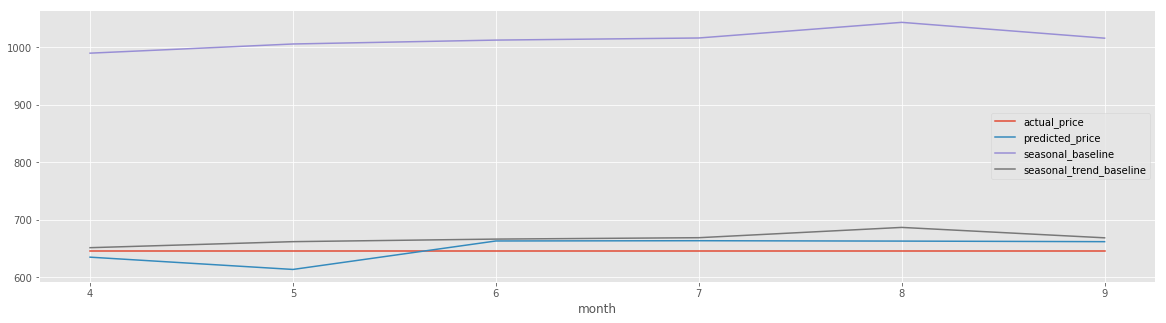

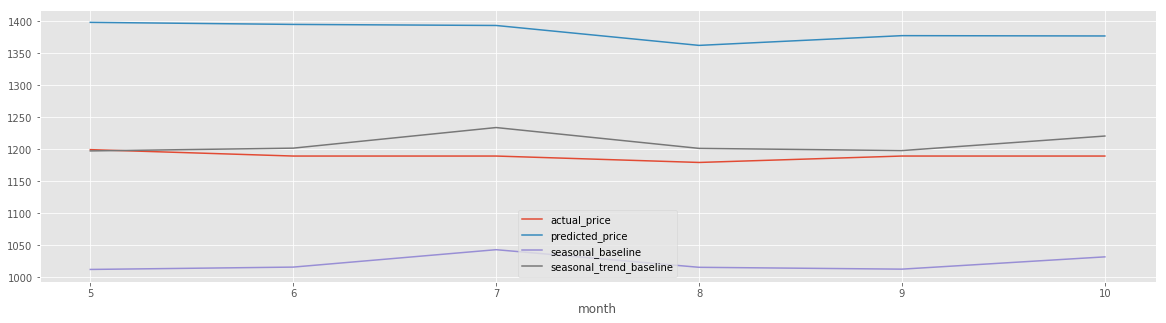

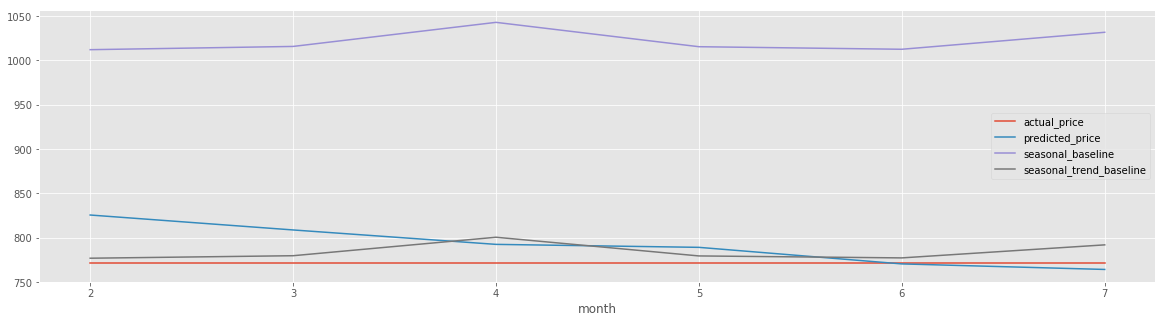

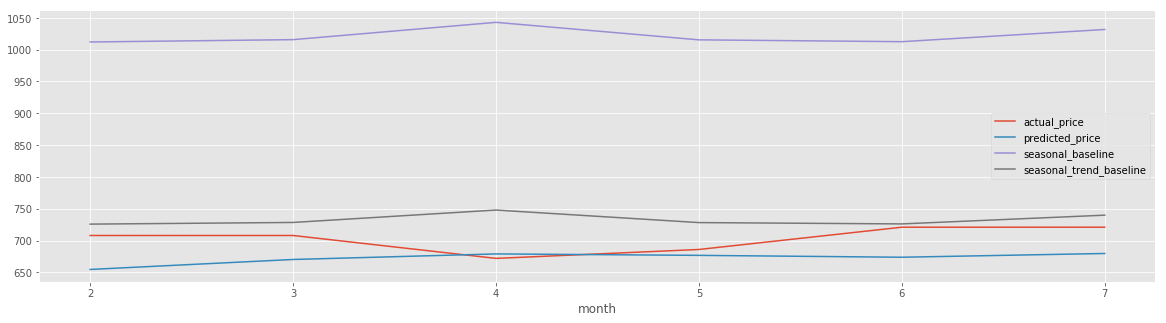

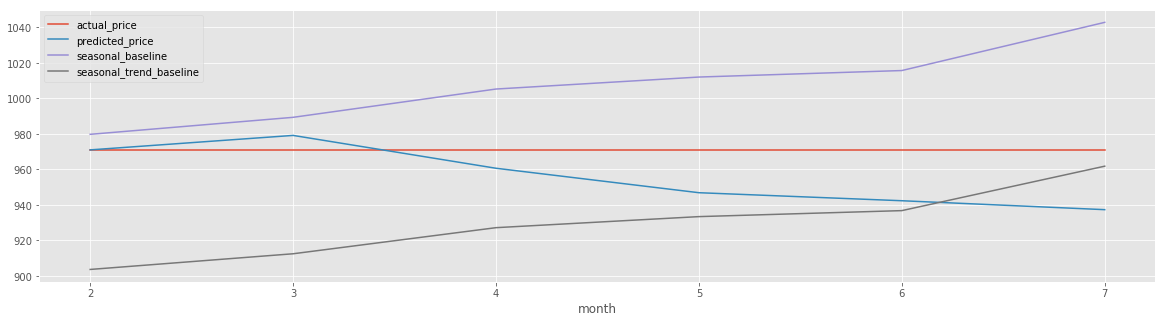

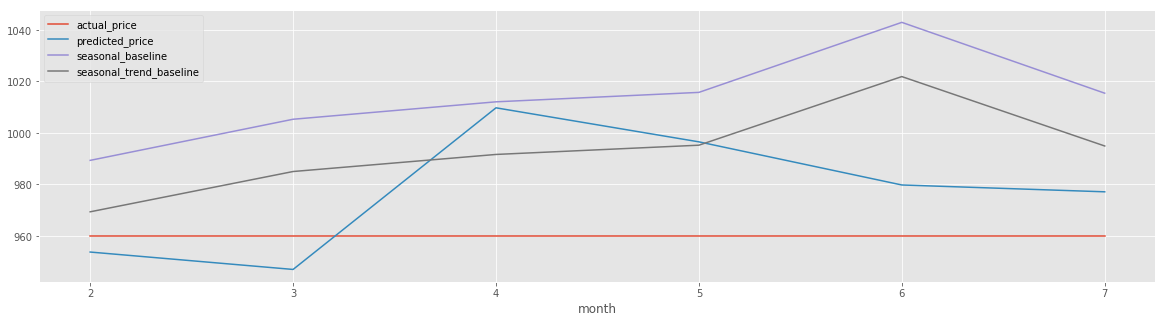

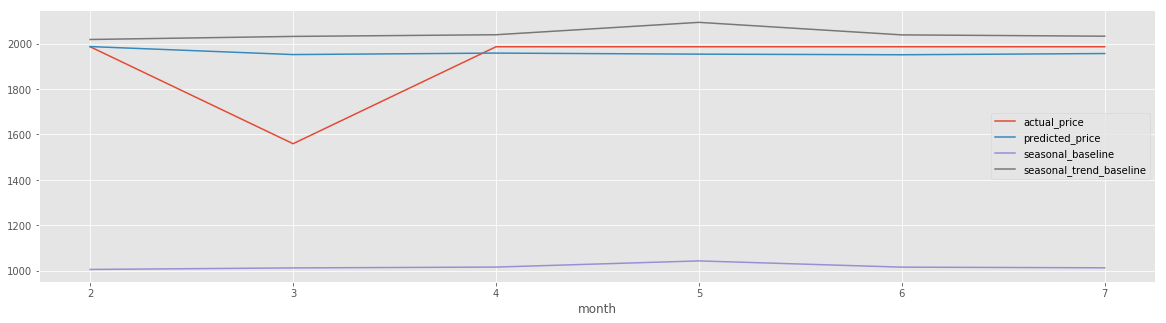

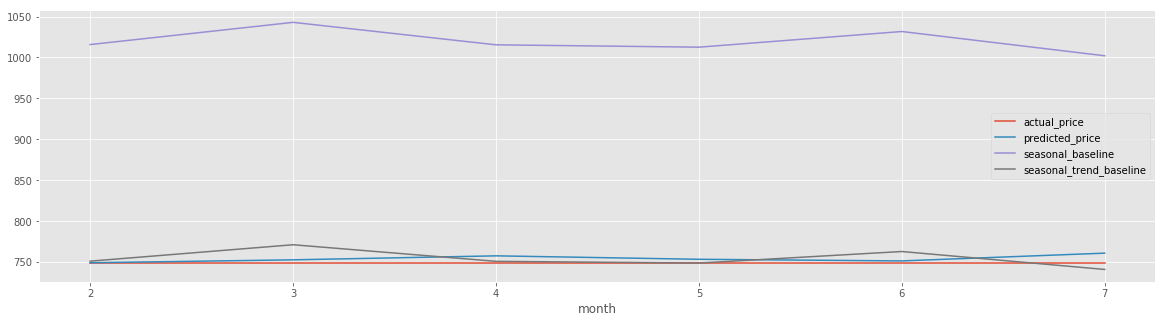

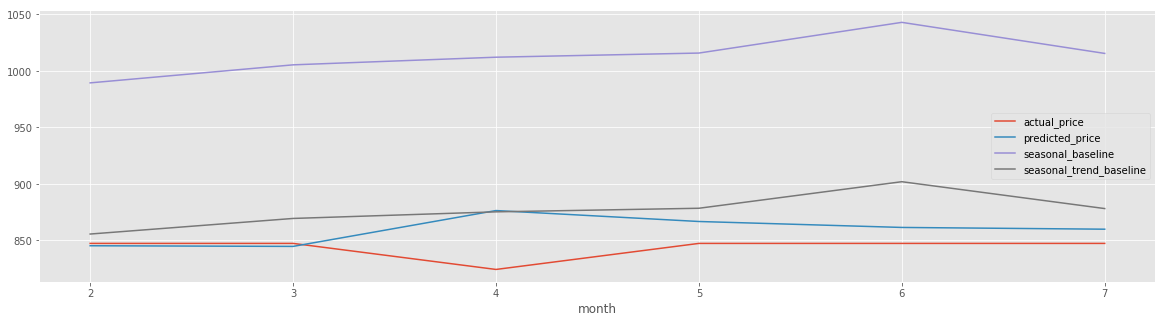

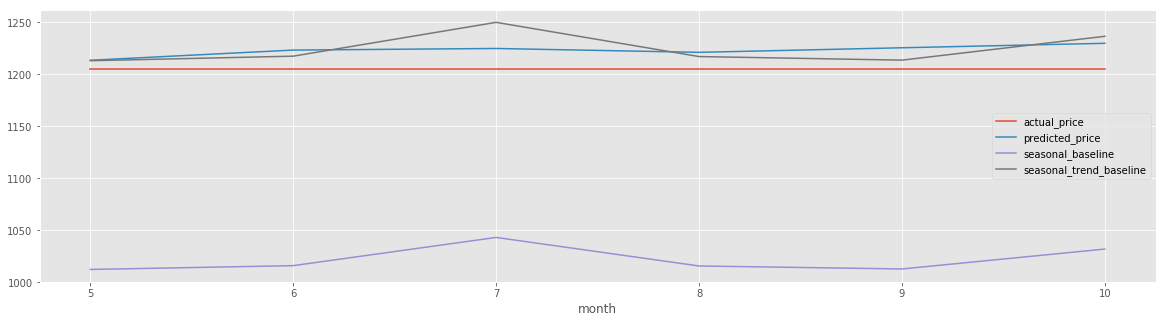

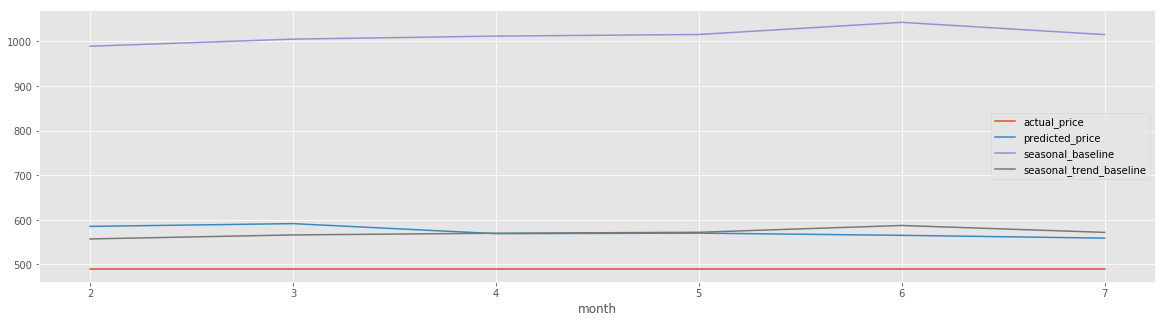

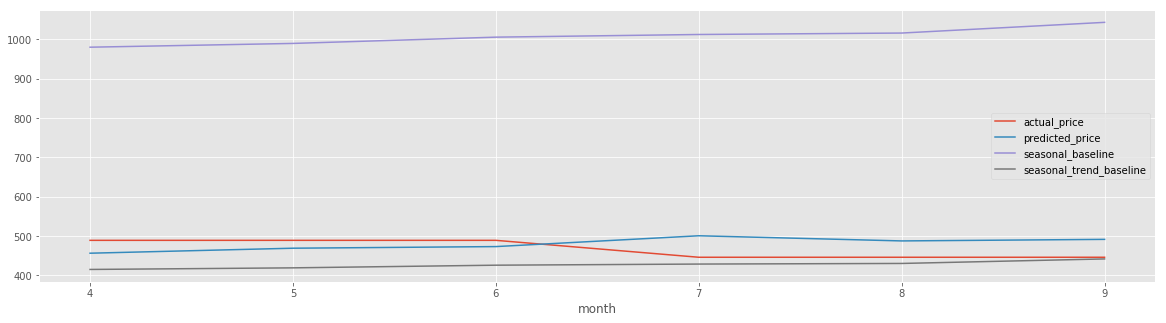

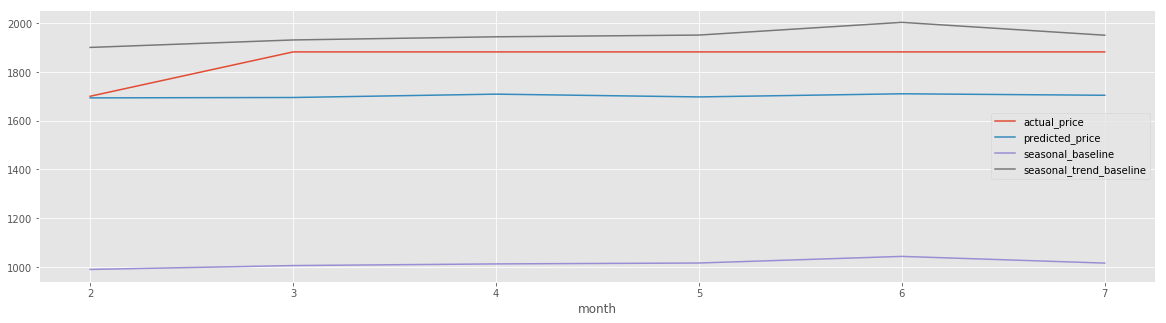

[2019-11-13 20:36:10,925] [DEBUG] [Cross validation finished] [--> /home/alexander/Documents/interviews/aboutyou/rent_price/src/train_model.py [22410]:]
[2019-11-13 20:36:10,926] [DEBUG] [{'predicted_price': 58.72019034157815, 'seasonal_baseline': 421.69338071154147, 'seasonal_trend_baseline': 52.956561994846666}] [--> /home/alexander/Documents/interviews/aboutyou/rent_price/src/train_model.py [22410]:]


In [27]:
from train_model import cross_validate
logger.setLevel(logging.DEBUG)
rmse = cross_validate(show_plots=True)
logger.setLevel(logging.INFO)

In [28]:
print('RMSE for the models: ' + str(rmse))

RMSE for the models: {'predicted_price': 58.72019034157815, 'seasonal_baseline': 421.69338071154147, 'seasonal_trend_baseline': 52.956561994846666}


Here we can see the the prediction plots for each sample in the test set and overall RMSE values for each model. Our model performs generally better than a simple seasonal model, and almost the same as the one scales seasonal trends to the current rent.

As demonstrated above, the performance could be improved through better handling of outliers.